In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU, LSTM
from tensorflow.keras.optimizers import Adam
from scipy.stats import norm
from scipy.linalg import svd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os 

# Fetch stock data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Compute technical indicators
def compute_technical_indicators(data):
    data['SMA30'] = data['Close'].rolling(window=30).mean()
    data['SMA100'] = data['Close'].rolling(window=100).mean()
    vol_window = 21
    data['Volatility'] = data['Close'].pct_change().rolling(window=vol_window).std() * np.sqrt(252)
    return data.dropna()

# Black-Scholes option pricing model
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Apply Black-Scholes model to generate option prices
def add_option_pricing_features(data):
    strike_price = data['Close'] * 1.05
    time_to_maturity = 30 / 252
    risk_free_rate = 0.01
    option_type = 'call'
    data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
    data['Implied_Volatility'] = data['Volatility']
    return data

# Normalize and apply PCA for dimensionality reduction
def preprocess_data(data, n_pca_components=2):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    # pca = PCA(n_components=n_pca_components)
    # data_pca = pca.fit_transform(data_scaled)
    # return np.hstack((data_scaled, data_pca))
    return data_scaled, scaler

# Create sequences for time-series prediction
def create_sequences(data, seq_len, pred_len):
    sequences = []
    for i in range(len(data) - seq_len - pred_len + 1):
        sequences.append(data[i:i + seq_len + pred_len])
    return np.array(sequences)

# Function to create a Hankel matrix
def create_hankel_matrix(time_series, window_size):
    # Create a Hankel matrix where the columns are shifted versions of the time series
    hankel_matrix = np.array([time_series[i:i + window_size] for i in range(len(time_series) - window_size + 1)])
    return hankel_matrix

# Function to perform SVD on the Hankel matrix
def hankel_svd(hankel_matrix):
    # Perform SVD on the Hankel matrix
    U, Sigma, Vt = svd(hankel_matrix, full_matrices=False)
    return U, Sigma, Vt

# Build a neural network model
def build_model(input_shape, output_len):
    model = Sequential([
    LSTM(200, activation='relu', return_sequences=False),  # LSTM layer
    Dense(180),
    LeakyReLU(),
    Dense(360),
    LeakyReLU(),
    Dense(360),
    LeakyReLU(),
    Dense(output_len)  # Output predictions for "Close" prices
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model



def predict_and_plot(m, ticker, data, s, model, seq_len, pred_len, scaler, cut_off):
    plt.figure(figsize=(14, 7))

    rmse_values = []  # To store RMSE values for each section
    section_start_idx = []  # To store the start indices of each 30-day section for placement of RMSE labels
    #s.shape[0]
    pred_count = 0
    red_x,red_y, black_y, blue_x, blue_y, green_y = [],[],[],[],[],[]
    for idx in range(0,s.shape[0], pred_len):  # Loop through each 30-day block
    # for idx in range(1): # only first 30 after being trained
        # Input remains in 3D for predictio
        future_input = s[idx, :seq_len, :].reshape(1, seq_len, -1)  # Keep the 3D shape
        future = model.predict(future_input)[0]  # Predict future "Close" prices
        # Pad the prediction with zeros for the "Volume" and "SMA" columns
        future_padded = np.hstack((future.reshape(-1, 1), np.zeros((future.shape[0], data.shape[1] - 3))))  # Adjust for PCA features

        # Inverse transform the padded prediction
        future_transform = scaler.inverse_transform(future_padded)[:, 0]  # Extract "Close"

        # Extract and inverse transform the true "Close" values
        future_true = s[idx, seq_len:, 0].reshape(-1, 1)  # Use only "Close"
        future_true_padded = np.hstack((future_true, np.zeros((future_true.shape[0], data.shape[1] - 3))))  # Adjust for PCA features
        future_true_transform = scaler.inverse_transform(future_true_padded)[:, 0]  # Extract "Close"

        # Calculate RMSE for this 30-day section
        percent_error = np.mean(np.abs((future_true_transform - future_transform) / future_true_transform)) * 100
        rmse_values.append(percent_error)
        section_start_idx.append(idx)  # Store the start index for the percentage error label
        if idx< cut_off:
            red_x +=[idx]
            red_y+=[future_transform]
            black_y+=[future_true_transform]
        else:
            blue_x +=[idx]
            blue_y+=[future_transform]
            green_y+=[future_true_transform]

        # # Plot the predictions
        # plt.scatter(idx, future_transform, 
        # # label="Train Prediction" if idx < cut_off else "Test Prediction", 
        #     color="red" if idx < cut_off else "blue")


        # # plt.plot(np.arange(idx, idx + pred_len), future_transform, 
        # #         # label="Train Prediction" if idx < cut_off else "Test Prediction", 
        # #          color="red" if idx < cut_off else "blue")

        # # Plot the true values
        # plt.scatter(idx, future_true_transform, 
        #          #label="Train True" if idx < cut_off else "Test True", 
        #          color="black" if idx < cut_off else "green")

        
        if idx >= cut_off:
            pred_count+=1
    plt.plot(red_x, red_y, color = "red")
    plt.plot(red_x, black_y, color = "black")
    plt.plot(blue_x, blue_y, color = "blue")
    plt.plot(blue_x, green_y, color = "green")
    # Add legend and grid
    # plt.legend(["Train Prediction", "Train True", "Test Prediction", "Test True"])
    plt.plot([], [], color="red", label="Train Prediction")  # Dummy plot for legend
    plt.plot([], [], color="black", label="Train True")      # Dummy plot for legend
    plt.plot([], [], color="blue", label="Test Prediction")  # Dummy plot for legend
    plt.plot([], [], color="green", label="Test True")      # Dummy plot for legend
    plt.legend()
    # for idx in range(0, s.shape[0], pred_len): 
    # Add vertical line to separate each 30-day section
        # plt.axvline(x=idx + pred_len, color='gray', linestyle='--', linewidth=1)
    # Title and labels
    
    plt.title(f"{seq_len}-{pred_len} Predictions for {ticker}, model {m}")
    plt.xlabel("Trading Days")
    plt.ylabel("Price")

    # Add RMSE labels below the x-axis at the start of each 30-day section
    # for i, rmse in zip(section_start_idx, rmse_values):
    #     plt.text(i + pred_len / 2, min(plt.ylim()), f"{rmse:.0f}", color="teal", fontsize=10, ha='center', va='top')
    # plt.text(- 5- pred_len / 2, min(plt.ylim()), f"RMSE", color="teal", fontsize=10, ha='center', va='top')
    # print(rmse_values)
    # plt.grid(True)
    if m == "LSTM w/ 7 features":
        dir = f"{seq_len}-{pred_len}/lstm_7"
        if not os.path.exists(dir):
                os.makedirs(dir)
        plt.savefig(f"{dir}/{ticker}.png")
    return np.mean(rmse_values[-pred_count]) # testing rmse

    # plt.show()

# Call the function


# Main workflow
def main(tickers):
    m = "LSTM w/ 7 features"
    test_rmse = []
    for ticker in tickers:
        # Step 1: Fetch data
        tsla = fetch_stock_data(ticker, start_date="2021-11-03", end_date="2024-12-01")

        # Step 2: Compute indicators
        tsla = compute_technical_indicators(tsla)

        # Step 3: Add Black-Scholes option pricing
        tsla = add_option_pricing_features(tsla)

        # Step 4: Prepare data for training
        features = ['Close', 'Volume', 'SMA30', 'SMA100', 'Volatility']
        data = tsla[features].copy()
        # Step 5: Perform Hankel Matrix Decomposition
        window_size = 2  # Size of the sliding window to form the Hankel matrix
        hankel_matrix = create_hankel_matrix(data['Close'].values, window_size)

        # Step 6: Perform SVD on the Hankel matrix
        U, Sigma, Vt = hankel_svd(hankel_matrix)

        # You can choose the first few singular values and modes to add as features
        num_modes = 2  # Number of modes to add as features
        dmd_modes = U[:, :num_modes]  # Select the modes
        dmd_amplitudes = Sigma[:num_modes]  # Select the amplitudes

        # Step 7: Normalize and apply PCA for dimensionality reduction
        processed_data,scaler = preprocess_data(data)

        # Trim the processed_data to match the number of rows in dmd_modes
        processed_data_trimmed = processed_data[-dmd_modes.shape[0]:]  # Trim to match the length of dmd_modes

        # Combine the Hankel decomposition modes with the processed data
        data_combined = np.hstack((processed_data_trimmed, dmd_modes))

        # Step 8: Create sequences for time-series prediction
        seq_len = 1  # 6 months of data
        pred_len = 1  # Predict the next 20 days
        sequences = create_sequences(data_combined, seq_len, pred_len)

        # Step 9: Split data into training and testing
        cut_off = int(0.8 * sequences.shape[0])
        X_train = sequences[:cut_off, :seq_len, :]
        X_test = sequences[cut_off:, :seq_len, :]
        y_train = sequences[:cut_off, seq_len:, 0]
        y_test = sequences[cut_off:, seq_len:, 0]
        print(sequences.shape)
        
        # Step 10: Build and train the model
        model = build_model(input_shape=(seq_len, X_train.shape[2]), output_len=pred_len)
        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            verbose=1
        )

        test_rmse += [predict_and_plot(m, ticker, data_combined, sequences, model, seq_len, pred_len, scaler, cut_off)]

    mse_for_model  = np.mean(test_rmse)
    return mse_for_model

2024-12-03 17:12:35.158259: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 17:12:35.180384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733267555.197755     302 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733267555.202544     302 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 17:12:35.222209: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[*********************100%***********************]  1 of 1 completed

(672, 2, 7)
Epoch 1/100



/tmp/ipykernel_302/2521892667.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_302/2521892667.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']
2024-12-03 17:12:37.205616: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UN

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1095
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0135
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011    
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012    
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3990e-04
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3424e-04
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4636e-04
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010    
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.7719e-04
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - l

[*********************100%***********************]  1 of 1 completed

(672, 2, 7)
Epoch 1/100



/tmp/ipykernel_302/2521892667.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_302/2521892667.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0330
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.1498e-04
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8813e-04
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1320e-04
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4202e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8774e-04
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6080e-04
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7155e-04
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9961e-04
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0229e-04
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6160e-04
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3589e-04
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2496e-04
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(672, 2, 7)
Epoch 1/100



/tmp/ipykernel_302/2521892667.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_302/2521892667.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - loss: 0.0890
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0073
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9880e-04
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7736e-04
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5340e-04
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8951e-04
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0526e-04
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4068e-04
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - lo

[*********************100%***********************]  1 of 1 completed

(672, 2, 7)
Epoch 1/100



/tmp/ipykernel_302/2521892667.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_302/2521892667.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0986
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0066
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0021
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.1870e-04
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9943e-04
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2301e-04
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1526e-04
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9333e-04
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8593e-04
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0556e-04
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.2129e-04
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms

[*********************100%***********************]  1 of 1 completed

(672, 2, 7)
Epoch 1/100



/tmp/ipykernel_302/2521892667.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_302/2521892667.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1909
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0217
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011    
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012    
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6226e-04
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9401e-04
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011    
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.9697e-04
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss

[*********************100%***********************]  1 of 1 completed

(672, 2, 7)
Epoch 1/100



/tmp/ipykernel_302/2521892667.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_302/2521892667.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1300
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0207
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015    
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 16/100

[*********************100%***********************]  1 of 1 completed

(672, 2, 7)
Epoch 1/100



/tmp/ipykernel_302/2521892667.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_302/2521892667.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0199
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.9309e-04
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3659e-04
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7338e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7710e-04
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2182e-04
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8780e-04
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8924e-04
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9909e-04
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5473e-04
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6787e-04
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8765e-04
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(672, 2, 7)
Epoch 1/100



/tmp/ipykernel_302/2521892667.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_302/2521892667.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1189
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010    
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8401e-04
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3361e-04
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.1014e-04
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1770e-04
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2

[*********************100%***********************]  1 of 1 completed

(672, 2, 7)
Epoch 1/100



/tmp/ipykernel_302/2521892667.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_302/2521892667.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1058
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011    
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.6929e-04
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2991e-04
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9513e-04
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3132e-04
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7476e-04
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2565e-04
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9380e-04
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3720e-04
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

[*********************100%***********************]  1 of 1 completed

(672, 2, 7)
Epoch 1/100



/tmp/ipykernel_302/2521892667.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
/tmp/ipykernel_302/2521892667.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Implied_Volatility'] = data['Volatility']


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0854
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.9402e-04
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2094e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4991e-04
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2429e-04
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7697e-04
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8559e-04
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1121e-04
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.5035e-04
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.5002e-04
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0431e-04
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 

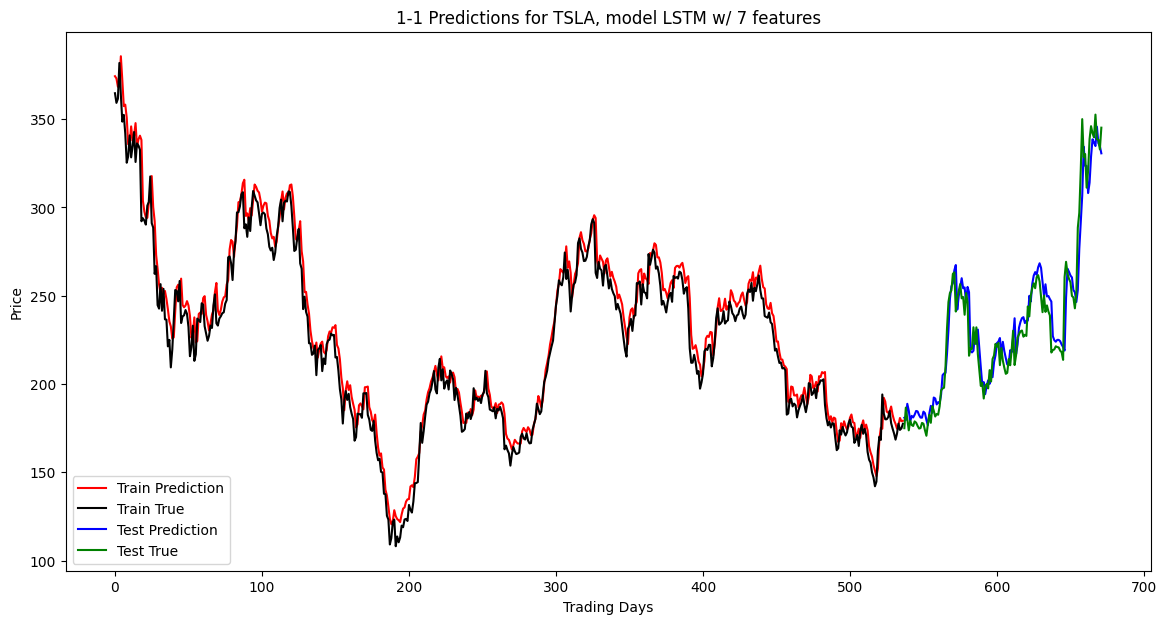

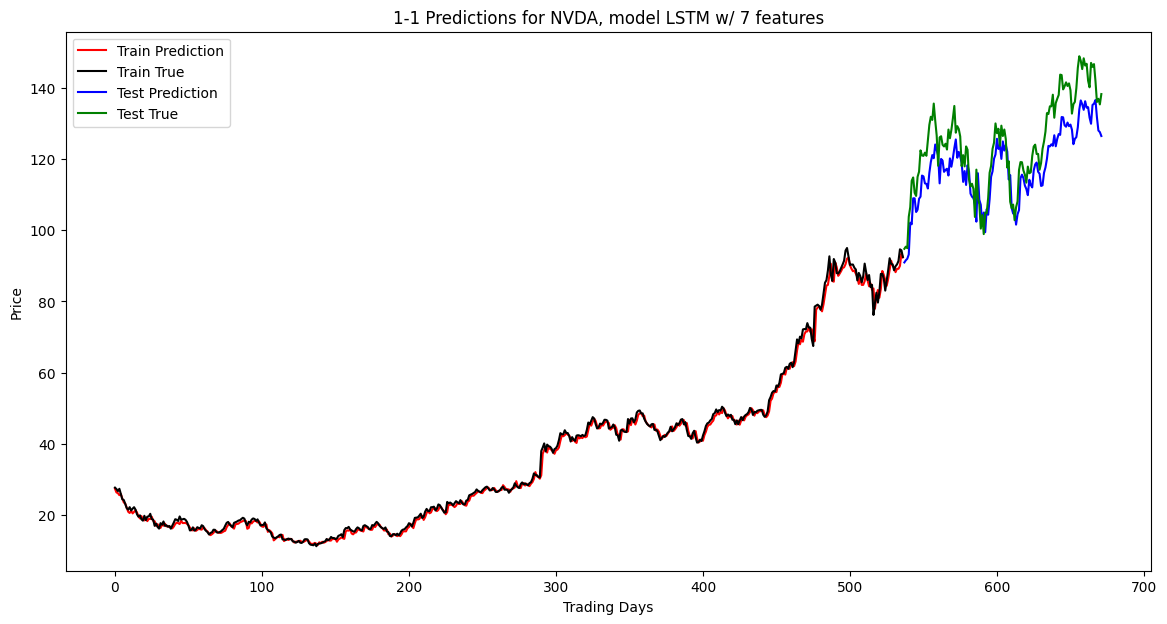

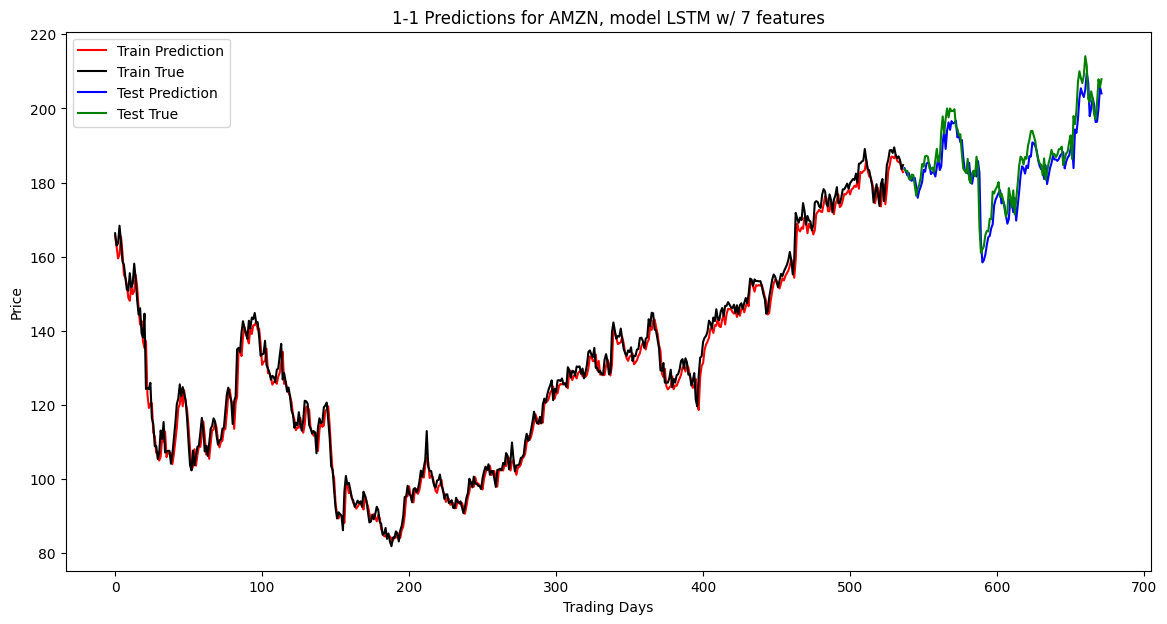

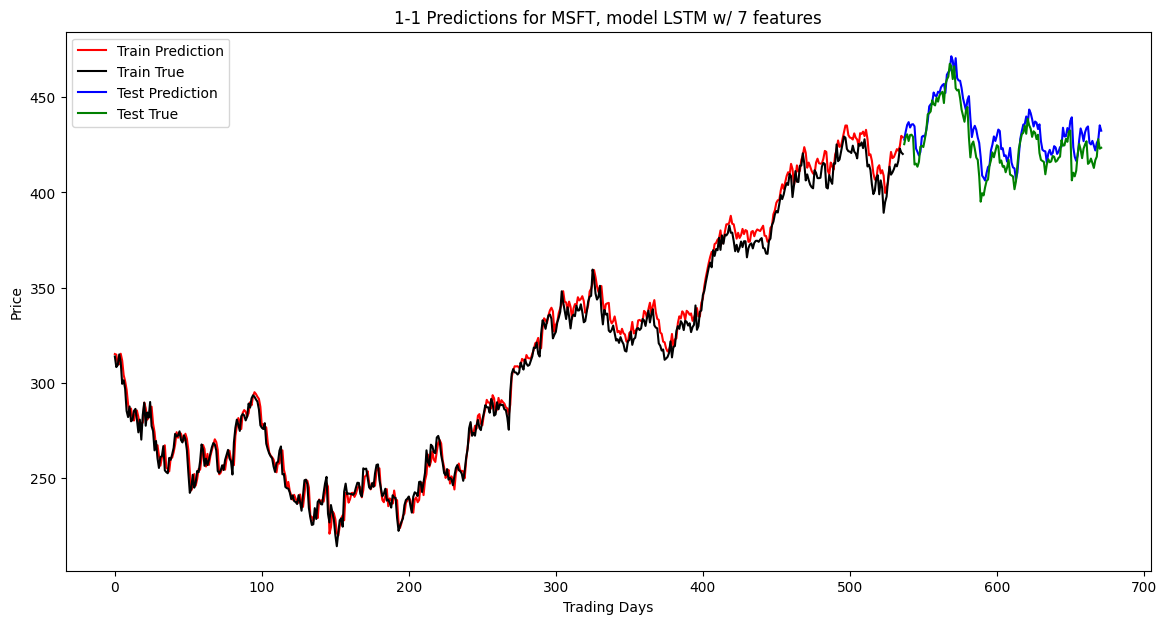

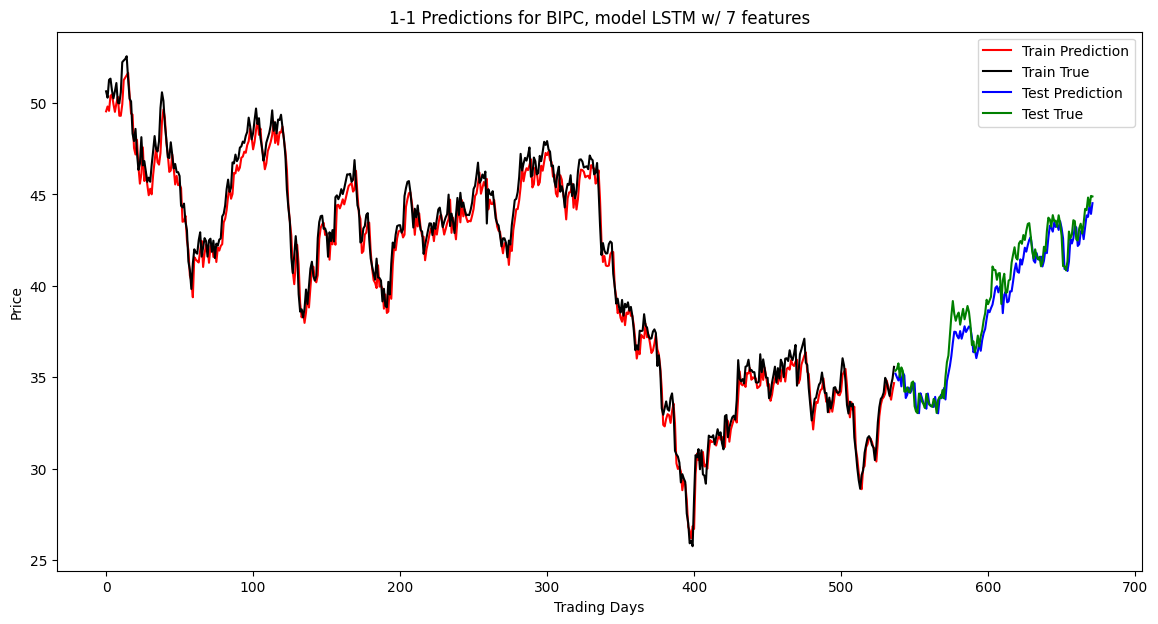

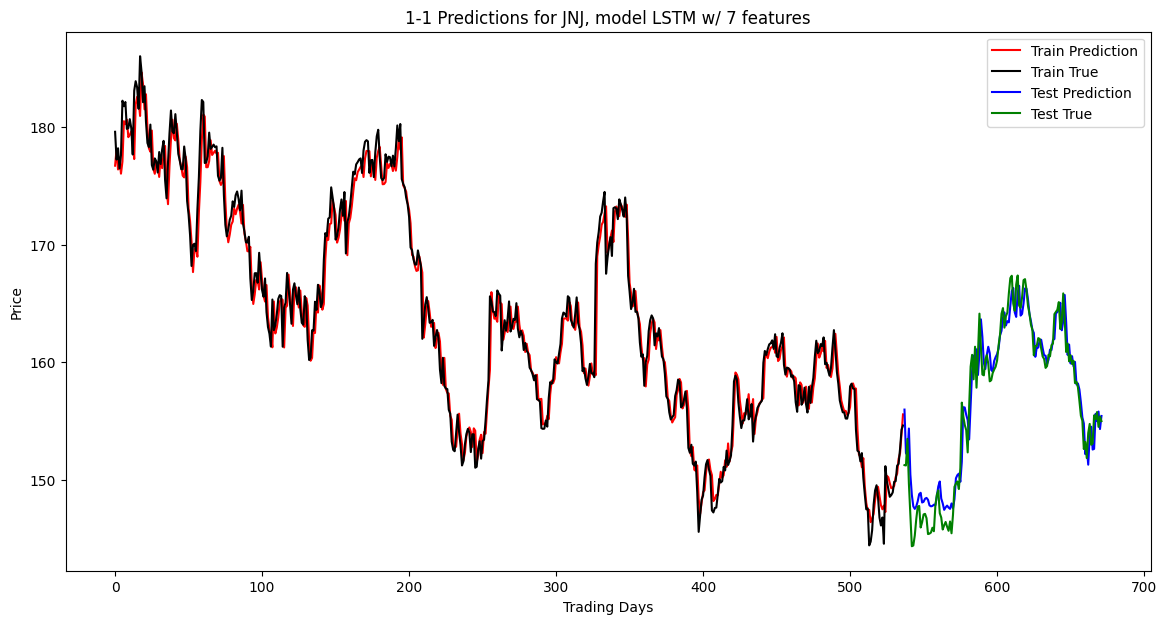

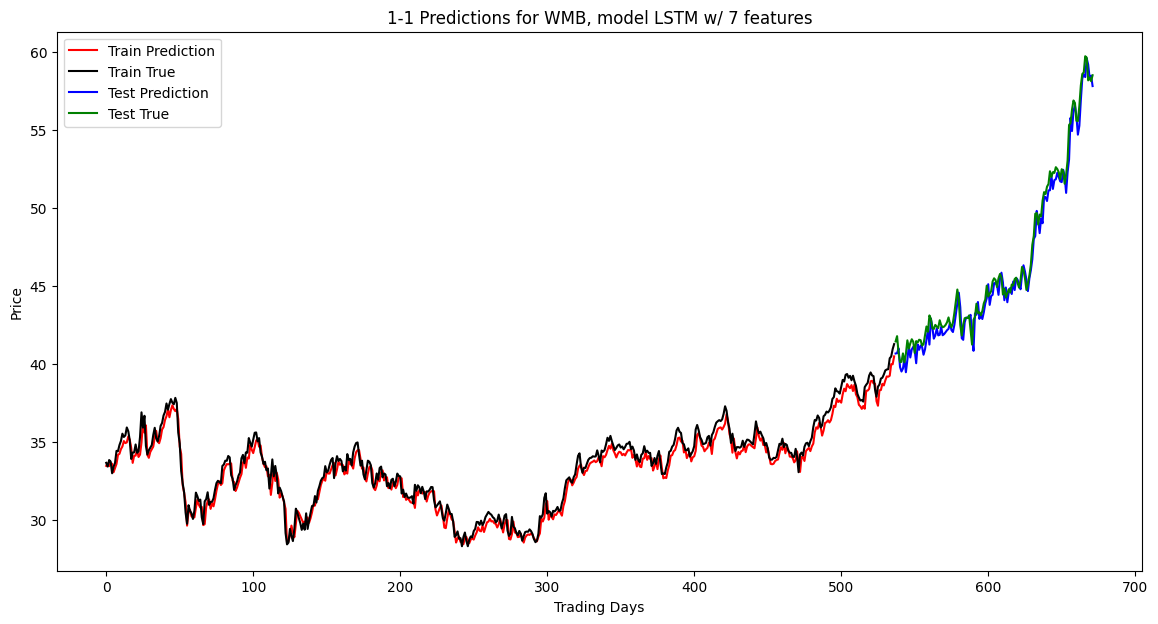

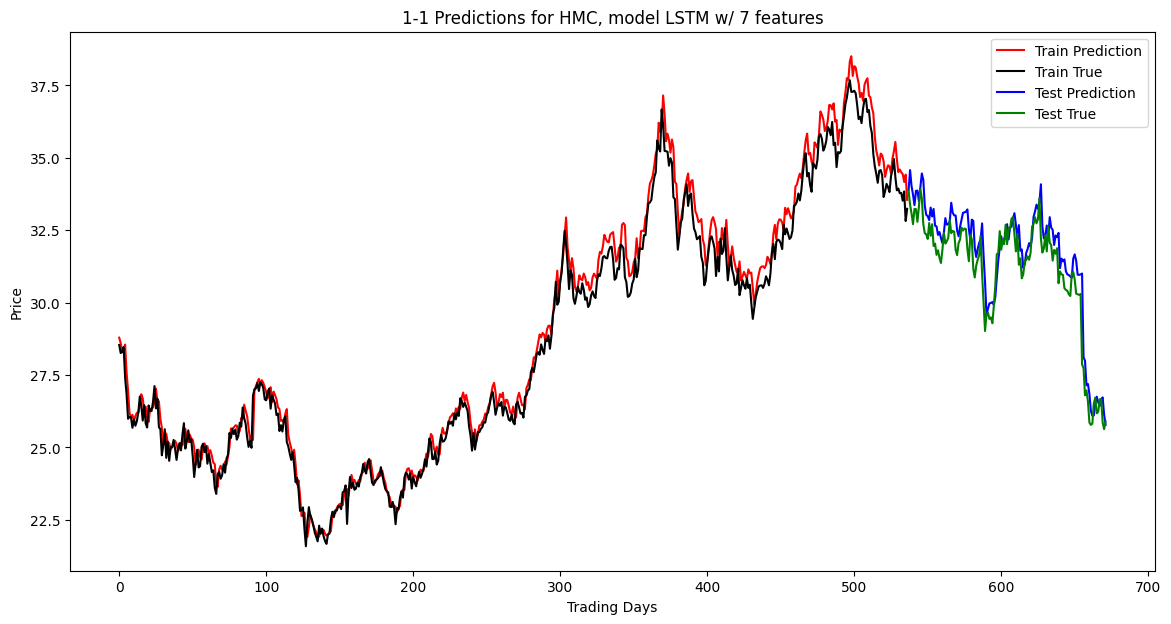

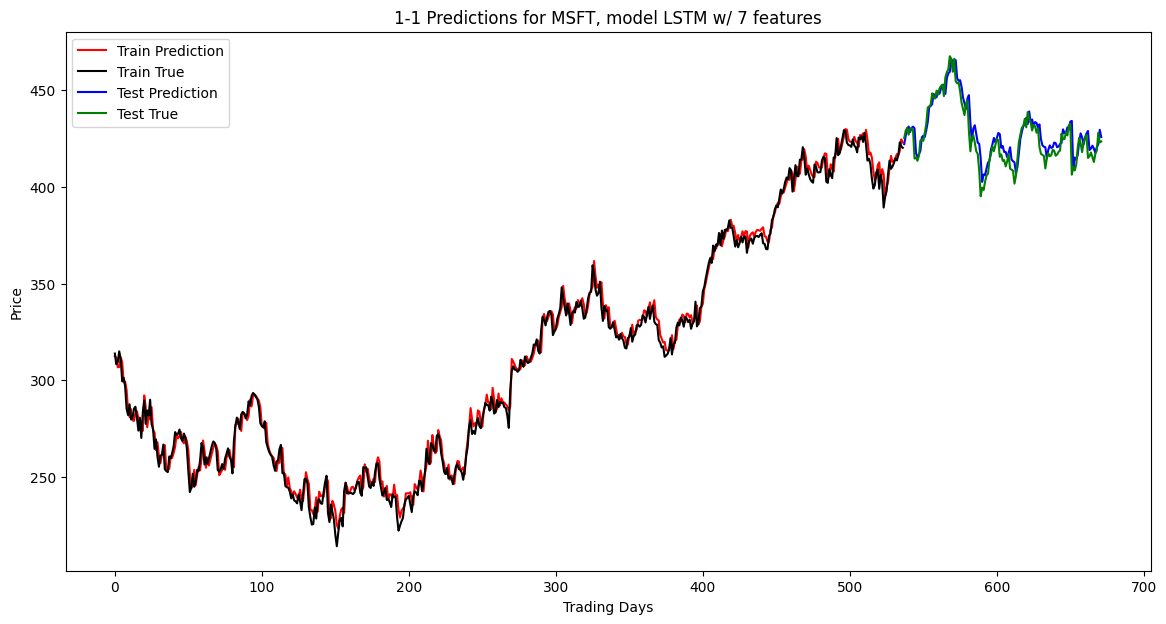

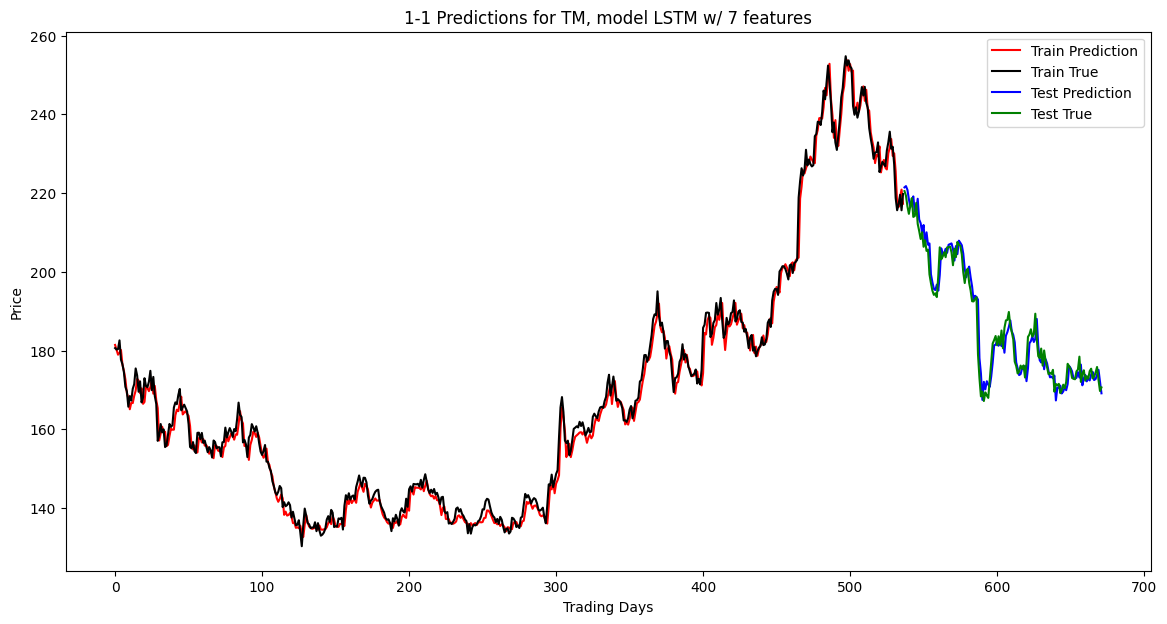

In [2]:
tickers = ["TSLA","NVDA","AMZN","MSFT", "BIPC", "JNJ","WMB","HMC","MSFT", "TM"]
mse = main(tickers)

In [3]:
mse
    

1.491042589513636